In [3]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.getOrCreate()

# Regression task

In [4]:
data=spark.read.parquet('sf-airbnb-clean.parquet/')

In [5]:
from pyspark.ml.feature import OneHotEncoder,StringIndexer,VectorAssembler

In [6]:
train,test= data.randomSplit([0.8,0.2],42)

In [7]:
categorical_features=[f for (f,v) in train.dtypes if v=='string']

In [8]:
categorical_features

['host_is_superhost',
 'cancellation_policy',
 'instant_bookable',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type']

In [9]:
numerical_features=[f for (f,v) in train.dtypes if (v=='double') &(v!='price')]

In [10]:
numerical_features

['host_total_listings_count',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'price',
 'bedrooms_na',
 'bathrooms_na',
 'beds_na',
 'review_scores_rating_na',
 'review_scores_accuracy_na',
 'review_scores_cleanliness_na',
 'review_scores_checkin_na',
 'review_scores_communication_na',
 'review_scores_location_na',
 'review_scores_value_na']

In [11]:
string_indxer_op=[c+'_indxer' for c in categorical_features]

In [12]:
string_indxer_op

['host_is_superhost_indxer',
 'cancellation_policy_indxer',
 'instant_bookable_indxer',
 'neighbourhood_cleansed_indxer',
 'property_type_indxer',
 'room_type_indxer',
 'bed_type_indxer']

In [13]:
ohe_op=[c+'_ohe' for c in categorical_features]

In [14]:
ohe_op

['host_is_superhost_ohe',
 'cancellation_policy_ohe',
 'instant_bookable_ohe',
 'neighbourhood_cleansed_ohe',
 'property_type_ohe',
 'room_type_ohe',
 'bed_type_ohe']

In [15]:
string_indxer=StringIndexer(inputCols=categorical_features,outputCols=string_indxer_op,handleInvalid='skip')

In [16]:
OHE=OneHotEncoder(inputCols=string_indxer_op,outputCols=ohe_op)

In [17]:
all_features=numerical_features+ohe_op

In [18]:
all_features

['host_total_listings_count',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'price',
 'bedrooms_na',
 'bathrooms_na',
 'beds_na',
 'review_scores_rating_na',
 'review_scores_accuracy_na',
 'review_scores_cleanliness_na',
 'review_scores_checkin_na',
 'review_scores_communication_na',
 'review_scores_location_na',
 'review_scores_value_na',
 'host_is_superhost_ohe',
 'cancellation_policy_ohe',
 'instant_bookable_ohe',
 'neighbourhood_cleansed_ohe',
 'property_type_ohe',
 'room_type_ohe',
 'bed_type_ohe']

In [19]:
vectassm=VectorAssembler(inputCols=all_features,outputCol='feature')

In [20]:
from pyspark.ml.regression import LinearRegression

In [21]:
lr=LinearRegression(featuresCol='feature',labelCol='price',predictionCol='preds')

In [22]:
from pyspark.ml.pipeline import Pipeline

In [23]:
pip=Pipeline(stages=[string_indxer,OHE,vectassm,lr])

In [24]:
model=pip.fit(train)

٢٢/٠٧/١٨ ١٠:٣٩:٤٦ WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
٢٢/٠٧/١٨ ١٠:٣٩:٥٠ WARN Instrumentation: [1c1baafc] regParam is zero, which might cause numerical instability and overfitting.
٢٢/٠٧/١٨ ١٠:٣٩:٥١ WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
٢٢/٠٧/١٨ ١٠:٣٩:٥١ WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
٢٢/٠٧/١٨ ١٠:٣٩:٥١ WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [25]:
predDF=model.transform(test)

In [26]:
predDF.select(['price','preds','feature']).show()

+------+------------------+--------------------+
| price|             preds|             feature|
+------+------------------+--------------------+
|  85.0| 84.99999999999983|(99,[0,1,2,3,4,5,...|
|  45.0| 44.99999999999982|(99,[0,1,2,3,4,5,...|
|  70.0| 69.99999999999982|(99,[0,1,2,3,4,5,...|
| 128.0| 127.9999999999998|(99,[0,1,2,3,4,5,...|
| 159.0|158.99999999999983|(99,[0,1,2,3,4,5,...|
| 250.0|249.99999999999983|(99,[0,1,2,3,4,5,...|
|  99.0| 98.99999999999982|(99,[0,1,2,3,4,5,...|
|  95.0| 94.99999999999979|(99,[0,1,2,3,4,5,...|
| 100.0| 99.99999999999979|(99,[0,1,2,3,4,5,...|
|2010.0|2009.9999999999998|(99,[0,1,2,3,4,5,...|
| 270.0|269.99999999999983|(99,[0,1,2,3,4,5,...|
| 500.0|499.99999999999983|(99,[0,1,2,3,4,5,...|
| 125.0|124.99999999999982|(99,[0,1,2,3,4,6,...|
| 210.0|209.99999999999983|(99,[0,1,2,3,4,5,...|
|  60.0| 59.99999999999981|(99,[0,1,2,3,4,5,...|
| 170.0|169.99999999999983|(99,[0,1,2,3,4,5,...|
| 214.0| 213.9999999999998|(99,[0,1,2,3,4,5,...|
| 120.0|119.99999999

In [27]:
from pyspark.ml.evaluation import RegressionEvaluator
Re=RegressionEvaluator(predictionCol='preds',labelCol='price')

In [28]:
rmse=Re.evaluate(predDF)

In [29]:
rmse

1.7773024164109634e-13

# Classification task

# Preprocessing

In [30]:
covid_data=spark.read.csv('PatientInfo.csv',header=True,inferSchema=True)

In [31]:
covid_data.show(5)

+----------+------+---+-------+--------+-----------+--------------------+-----------+--------------+------------------+--------------+-------------+-------------+--------+
|patient_id|   sex|age|country|province|       city|      infection_case|infected_by|contact_number|symptom_onset_date|confirmed_date|released_date|deceased_date|   state|
+----------+------+---+-------+--------+-----------+--------------------+-----------+--------------+------------------+--------------+-------------+-------------+--------+
|1000000001|  male|50s|  Korea|   Seoul| Gangseo-gu|     overseas inflow|       null|            75|        2020-01-22|    2020-01-23|   2020-02-05|         null|released|
|1000000002|  male|30s|  Korea|   Seoul|Jungnang-gu|     overseas inflow|       null|            31|              null|    2020-01-30|   2020-03-02|         null|released|
|1000000003|  male|50s|  Korea|   Seoul|  Jongno-gu|contact with patient| 2002000001|            17|              null|    2020-01-30|   202

In [32]:
covid_data.printSchema()

root
 |-- patient_id: long (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- country: string (nullable = true)
 |-- province: string (nullable = true)
 |-- city: string (nullable = true)
 |-- infection_case: string (nullable = true)
 |-- infected_by: string (nullable = true)
 |-- contact_number: string (nullable = true)
 |-- symptom_onset_date: string (nullable = true)
 |-- confirmed_date: string (nullable = true)
 |-- released_date: string (nullable = true)
 |-- deceased_date: string (nullable = true)
 |-- state: string (nullable = true)



In [33]:
covid_data.describe().show()

+-------+--------------------+------+----+----------+--------+--------------+--------------------+--------------------+--------------------+------------------+--------------+-------------+-------------+--------+
|summary|          patient_id|   sex| age|   country|province|          city|      infection_case|         infected_by|      contact_number|symptom_onset_date|confirmed_date|released_date|deceased_date|   state|
+-------+--------------------+------+----+----------+--------+--------------+--------------------+--------------------+--------------------+------------------+--------------+-------------+-------------+--------+
|  count|                5165|  4043|3785|      5165|    5165|          5071|                4246|                1346|                 791|               690|          5162|         1587|           66|    5165|
|   mean|2.8636345618679576E9|  null|null|      null|    null|          null|                null|2.2845944015643125E9|1.6772572523506988E7|            

In [34]:
covid_data.select(covid_data['state']).show(3)

+--------+
|   state|
+--------+
|released|
|released|
|released|
+--------+
only showing top 3 rows



In [35]:
from pyspark.sql.functions import *

In [36]:
covid_data.select(col('state')).where(col('state')=='released').count()

2929

In [37]:
covid_data.select(col('state')).where(col('state')!='released').count()

2236

In [38]:
covid_data.select([ count(when(isnull(c),c)).alias(c) for c in covid_data.columns]).show(3)

+----------+----+----+-------+--------+----+--------------+-----------+--------------+------------------+--------------+-------------+-------------+-----+
|patient_id| sex| age|country|province|city|infection_case|infected_by|contact_number|symptom_onset_date|confirmed_date|released_date|deceased_date|state|
+----------+----+----+-------+--------+----+--------------+-----------+--------------+------------------+--------------+-------------+-------------+-----+
|         0|1122|1380|      0|       0|  94|           919|       3819|          4374|              4475|             3|         3578|         5099|    0|
+----------+----+----+-------+--------+----+--------------+-----------+--------------+------------------+--------------+-------------+-------------+-----+



In [39]:
covid_data.select(count(when(col('state')=='released',col('state'))).alias('count')).show()

+-----+
|count|
+-----+
| 2929|
+-----+



In [40]:
covid_data.select(coalesce(covid_data['released_date'],covid_data['deceased_date'])).show()

+--------------------------------------+
|coalesce(released_date, deceased_date)|
+--------------------------------------+
|                            2020-02-05|
|                            2020-03-02|
|                            2020-02-19|
|                            2020-02-15|
|                            2020-02-24|
|                            2020-02-19|
|                            2020-02-10|
|                            2020-02-24|
|                            2020-02-21|
|                            2020-02-29|
|                            2020-02-29|
|                            2020-02-27|
|                                  null|
|                            2020-03-12|
|                                  null|
|                            2020-03-11|
|                            2020-03-01|
|                                  null|
|                            2020-03-08|
|                                  null|
+--------------------------------------+
only showing top

In [41]:
covid_data=covid_data.withColumn('deceased_date',coalesce(covid_data['deceased_date'],covid_data['released_date']))

In [42]:
covid_data.select(col('deceased_date')).show()

+-------------+
|deceased_date|
+-------------+
|   2020-02-05|
|   2020-03-02|
|   2020-02-19|
|   2020-02-15|
|   2020-02-24|
|   2020-02-19|
|   2020-02-10|
|   2020-02-24|
|   2020-02-21|
|   2020-02-29|
|   2020-02-29|
|   2020-02-27|
|         null|
|   2020-03-12|
|         null|
|   2020-03-11|
|   2020-03-01|
|         null|
|   2020-03-08|
|         null|
+-------------+
only showing top 20 rows



In [43]:
covid_data=covid_data.withColumn('released_date',to_timestamp(col('released_date'),'yyyy-MM-dd'))

In [44]:
covid_data=covid_data.withColumn('deceased_date',to_timestamp(col('deceased_date'),'yyy-MM-dd'))

In [45]:
covid_data=covid_data.withColumn('confirmed_date',to_timestamp(col('confirmed_date'),'yyy-MM-dd'))

In [46]:
covid_data=covid_data.withColumn('no_days',datediff(col('confirmed_date'),col('deceased_date')))

In [47]:
covid_data.select('no_days').show()

+-------+
|no_days|
+-------+
|    -13|
|    -32|
|    -20|
|    -16|
|    -24|
|    -19|
|    -10|
|    -22|
|    -16|
|    -24|
|    -23|
|    -20|
|   null|
|    -25|
|   null|
|    -21|
|    -10|
|   null|
|    -17|
|   null|
+-------+
only showing top 20 rows



In [48]:
covid_data=covid_data.withColumn('is_male',when(col('sex')=='male',1).otherwise(0))

In [49]:
covid_data.select('is_male').show()

+-------+
|is_male|
+-------+
|      1|
|      1|
|      1|
|      1|
|      0|
|      0|
|      1|
|      1|
|      1|
|      0|
|      0|
|      1|
|      1|
|      0|
|      1|
|      1|
|      1|
|      1|
|      0|
|      0|
+-------+
only showing top 20 rows



In [50]:
covid_data=covid_data.withColumn('is_dead',when(col('state')!='released',1).otherwise(0))

In [51]:
covid_data.select('age').show()

+---+
|age|
+---+
|50s|
|30s|
|50s|
|20s|
|20s|
|50s|
|20s|
|20s|
|30s|
|60s|
|50s|
|20s|
|80s|
|60s|
|70s|
|70s|
|70s|
|20s|
|70s|
|70s|
+---+
only showing top 20 rows



In [52]:
covid_data=covid_data.withColumn('age',split(col('age'),'s').getItem(0))

In [53]:
covid_data.select('age').show()

+---+
|age|
+---+
| 50|
| 30|
| 50|
| 20|
| 20|
| 50|
| 20|
| 20|
| 30|
| 60|
| 50|
| 20|
| 80|
| 60|
| 70|
| 70|
| 70|
| 20|
| 70|
| 70|
+---+
only showing top 20 rows



In [54]:
covid_data=covid_data.withColumn('age',col('age').cast('Double'))

In [55]:
covid_data=covid_data.drop("patient_id","sex","infected_by","contact_number","released_date","state", "symptom_onset_date","confirmed_date","deceased_date","country","no_days", "city","infection_case")

In [56]:
covid_data.show()

+----+--------+-------+-------+
| age|province|is_male|is_dead|
+----+--------+-------+-------+
|50.0|   Seoul|      1|      0|
|30.0|   Seoul|      1|      0|
|50.0|   Seoul|      1|      0|
|20.0|   Seoul|      1|      0|
|20.0|   Seoul|      0|      0|
|50.0|   Seoul|      0|      0|
|20.0|   Seoul|      1|      0|
|20.0|   Seoul|      1|      0|
|30.0|   Seoul|      1|      0|
|60.0|   Seoul|      0|      0|
|50.0|   Seoul|      0|      0|
|20.0|   Seoul|      1|      0|
|80.0|   Seoul|      1|      1|
|60.0|   Seoul|      0|      0|
|70.0|   Seoul|      1|      0|
|70.0|   Seoul|      1|      0|
|70.0|   Seoul|      1|      0|
|20.0|   Seoul|      1|      0|
|70.0|   Seoul|      0|      0|
|70.0|   Seoul|      0|      0|
+----+--------+-------+-------+
only showing top 20 rows



In [57]:
covid_data.select([ count(when(isnull(c),c)) for c in covid_data.columns]).show()

+-------------------------------------------+-----------------------------------------------------+---------------------------------------------------+---------------------------------------------------+
|count(CASE WHEN (age IS NULL) THEN age END)|count(CASE WHEN (province IS NULL) THEN province END)|count(CASE WHEN (is_male IS NULL) THEN is_male END)|count(CASE WHEN (is_dead IS NULL) THEN is_dead END)|
+-------------------------------------------+-----------------------------------------------------+---------------------------------------------------+---------------------------------------------------+
|                                       1380|                                                    0|                                                  0|                                                  0|
+-------------------------------------------+-----------------------------------------------------+---------------------------------------------------+---------------------------------

# model

In [58]:
covid_data.printSchema()

root
 |-- age: double (nullable = true)
 |-- province: string (nullable = true)
 |-- is_male: integer (nullable = false)
 |-- is_dead: integer (nullable = false)



In [59]:
covid_data=covid_data.withColumn('is_male',col('is_male').cast('Double'))
covid_data=covid_data.withColumn('is_dead',col('is_dead').cast('Double'))

In [60]:
covid_data.printSchema()

root
 |-- age: double (nullable = true)
 |-- province: string (nullable = true)
 |-- is_male: double (nullable = false)
 |-- is_dead: double (nullable = false)



In [61]:
from  pyspark.ml.feature import StringIndexer,OneHotEncoder,Imputer,VectorAssembler

In [62]:
train,test=covid_data.randomSplit([0.8,0.2],2)

In [63]:
categorical_features=[f for (f,v) in train.dtypes if v=='string']

In [64]:
categorical_features

['province']

In [65]:
numerical_features=['age','is_male']

In [66]:
numerical_features

['age', 'is_male']

In [67]:
string_indxer_op=[c+'_indexer' for c in categorical_features]
ohe_op=[c+'_ohe' for c in categorical_features]
imp_op=[c+'_imputed' for c in numerical_features]

In [68]:
strindxer=StringIndexer(inputCols=categorical_features
                       ,outputCols=string_indxer_op)

ohe=OneHotEncoder(inputCols=string_indxer_op,outputCols=ohe_op)

imputer=Imputer(inputCols=numerical_features,strategy='mean',
                outputCols=imp_op)

all_features=ohe_op+imp_op
vectasm=VectorAssembler(inputCols=all_features,outputCol='feature')


In [69]:
from pyspark.ml.classification import NaiveBayes

In [70]:
nb=NaiveBayes(featuresCol='feature',predictionCol='preds',labelCol='is_dead')

In [71]:
from pyspark.ml.pipeline import Pipeline

In [72]:
pip=Pipeline(stages=[strindxer,ohe,imputer,vectasm,nb])

In [73]:
model=pip.fit(train)

In [74]:
predsDF=model.transform(test)

In [75]:
predsDF.select(['feature','preds','is_dead']).show()

+--------------------+-----+-------+
|             feature|preds|is_dead|
+--------------------+-----+-------+
|(18,[2,16],[1.0,4...|  1.0|    1.0|
|(18,[2,16],[1.0,4...|  1.0|    1.0|
|(18,[2,16],[1.0,4...|  1.0|    1.0|
|(18,[2,16],[1.0,4...|  1.0|    1.0|
|(18,[2,16],[1.0,4...|  1.0|    1.0|
|(18,[2,16],[1.0,4...|  1.0|    1.0|
|(18,[2,16],[1.0,4...|  1.0|    1.0|
|(18,[2,16],[1.0,4...|  1.0|    1.0|
|(18,[2,16],[1.0,4...|  1.0|    1.0|
|(18,[2,16],[1.0,4...|  1.0|    1.0|
|(18,[2,16],[1.0,4...|  1.0|    1.0|
|(18,[2,16],[1.0,4...|  1.0|    1.0|
|(18,[2,16],[1.0,4...|  1.0|    1.0|
|(18,[2,16],[1.0,4...|  1.0|    1.0|
|(18,[2,16],[1.0,4...|  1.0|    1.0|
|(18,[2,16],[1.0,4...|  1.0|    1.0|
|(18,[2,16],[1.0,4...|  1.0|    1.0|
|(18,[2,16],[1.0,4...|  1.0|    1.0|
|(18,[2,16],[1.0,4...|  1.0|    1.0|
|(18,[2,16],[1.0,4...|  1.0|    1.0|
+--------------------+-----+-------+
only showing top 20 rows



In [76]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [77]:
nb_ev=BinaryClassificationEvaluator(labelCol='is_dead',rawPredictionCol='preds')

In [78]:
nb_ev.evaluate(predsDF)

0.854410585404972

# Clustering

In [1]:
from pyspark.ml.clustering import KMeans

In [2]:
from pyspark import SparkContext
sc = SparkContext("local", "Simple App")

٢٢/٠٧/١٨ ١٠:٣٩:٣٤ WARN Utils: Your hostname, mohand-Lenovo-ideapad-310-15IKB resolves to a loopback address: 127.0.1.1; using 192.168.1.17 instead (on interface wlp2s0)
٢٢/٠٧/١٨ ١٠:٣٩:٣٤ WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
٢٢/٠٧/١٨ ١٠:٣٩:٣٥ WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
٢٢/٠٧/١٨ ١٠:٣٩:٣٥ WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import seaborn as sns

In [133]:
n_samples=10000
n_features=3
X, y = make_blobs(n_samples=n_samples, centers=3, n_features=n_features, random_state=42)

In [134]:
df=pd.DataFrame(X,columns=['x','y','z'])

In [135]:
df

,x,y,z
0,0.689927,-7.790698,-5.249491
1,-9.326063,5.669771,3.245473
2,-8.344055,6.009662,2.255320
3,-8.220472,6.551106,1.291325
4,-0.986486,8.228586,6.138346
...,...,...,...
9995,-10.401517,8.468296,1.731285
9996,-7.764441,6.151103,3.403646
9997,3.822538,-5.792689,-8.228827
9998,-9.916196,6.751302,0.092884


/home/mohand/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


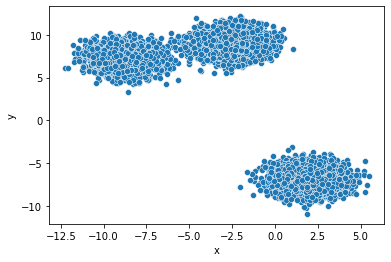

In [136]:
sns.scatterplot(df['x'],df['y']);

In [137]:
data_clustering=df.to_csv('clustering_dataset.csv')

In [138]:
spark_df=spark.read.csv('clustering_dataset.csv',header=True,inferSchema=True)

In [139]:
spark_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)



In [140]:
spark_df.show()

+---+-------------------+------------------+-------------------+
|_c0|                  x|                 y|                  z|
+---+-------------------+------------------+-------------------+
|  0| 0.6899271167947574|-7.790698277430851| -5.249490613159584|
|  1| -9.326062752208909|5.6697705804158876| 3.2454733525829216|
|  2|  -8.34405486266206|   6.0096617553112|  2.255319917567878|
|  3| -8.220472342879457| 6.551105663165592|  1.291324791398138|
|  4|  -0.98648632375658| 8.228585907319978|  6.138346160365143|
|  5|  -8.79564383993836| 7.563380783051231| 1.9289011112247587|
|  6|-3.6739970204218726| 9.154300615073936|  4.932830669746936|
|  7|  -9.69921085371959|   8.8197212703262|  2.434610428897709|
|  8| -9.677356792542135| 7.279051835708259| 2.4454226022159964|
|  9| 0.9187894886953158|-6.324181008948341| -4.894164817187939|
| 10|   2.75642586798614|-5.799929007674713| -7.210555057875675|
| 11|  2.239255105007773| -6.24240909979595|  -6.06812574064193|
| 12|-1.9777079349060922|

٢٢/٠٧/١٨ ١١:١١:٣١ WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , x, y, z
 Schema: _c0, x, y, z
Expected: _c0 but found: 
CSV file: file:///home/mohand/Desktop/Spark/Day2/clustering_dataset.csv


In [141]:
df_final=spark_df.select(['x','y','z'])

In [142]:
df_final=df_final.na.drop()

In [143]:
vectasm1=VectorAssembler(inputCols=['x','y','z'],outputCol='feature')

In [144]:
kmeans=KMeans(featuresCol='feature',predictionCol='preds',k=3)

In [145]:
from pyspark.ml.pipeline import Pipeline
pip=Pipeline(stages=[vectasm1,kmeans])

In [146]:
model=pip.fit(df_final)

In [147]:
preds_df=model.transform(df_final)

In [148]:
predictions=preds_df.select('x','y','preds')

In [149]:
pandas_preds=predictions.toPandas()

In [150]:
pandas_preds.head()

,x,y,preds
0,0.689927,-7.790698,1
1,-9.326063,5.669771,2
2,-8.344055,6.009662,2
3,-8.220472,6.551106,2
4,-0.986486,8.228586,0


/home/mohand/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


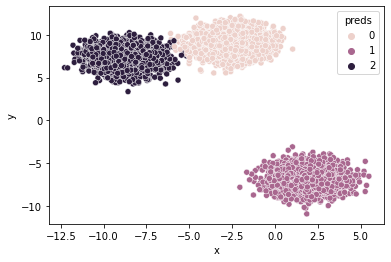

In [151]:
sns.scatterplot(pandas_preds['x'],pandas_preds['y'],hue=pandas_preds['preds']);

In [152]:
from pyspark.ml.evaluation import ClusteringEvaluator

In [153]:
kmev=ClusteringEvaluator(featuresCol='feature',predictionCol='preds')

In [154]:
kmev.evaluate(final_df)

0.9447206969084606